# Detection limits

If we define:

- $S$ (blue area): the fluorescence counts belonging to the emission lines of interest within a ROI of the XRF spectrum
- $B$ (orange area): the counts belonging to everything else (other emission lines, escape peaks, tails for neighbouring peaks, ...)
- $T=S+B$

then there are different figures-of-merit that can be used to determine a detection limit for $S$ (or rather the elemental concentration that results in $S$). We will assume Poisson statistics.

## Signal-to-noise
The signal-to-noise ratio can be expressed as
$$
\begin{equation}
\text{SNR}=\frac{T-B}{\sqrt{T+B}}
\end{equation}
$$
If we take $\text{SNR}=2$ as the lowest acceptable limit (95% chance that T differs significantly from B) then the detection limit is the elemental concentration that corresponds to $S_{\text{DL}}$
$$
\begin{equation}
S_{\text{DL}} = 2\sqrt{T+B}
\end{equation}
$$
In text books this is often further approximated by assuming that at the detection limit $T\approx B$ so that $S_{\text{DL}}\approx 2\sqrt{2B}\approx 3\sqrt{B}$.

## Least-squares
Since XRF spectra fitting is done by linear least-squares optimization, it is more appropriate to describe as such
$$
\begin{equation}
T(E)=A\cdot\begin{bmatrix}S\\B\end{bmatrix}
\quad\quad
A=\begin{bmatrix}S_n(E)&B_n(E)\\ \vdots&\vdots\end{bmatrix}
\end{equation}
$$
where the columns of $A$ are the normalized basis vectors for the linear decomposition. The covariance matrix of the solution is
$$
\begin{equation}
\text{COV}_{S,B}=(A^T\cdot\text{COV}_{T_(E)}\cdot A)^{-1}
\quad\quad
\text{COV}_{S,B}=\begin{bmatrix}
\sigma^2_S &\sigma_{S,B}\\
\sigma_{B,S}&\sigma^2_B
\end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
\text{COR}_{S,B}=D^{-1}\cdot\text{COV}_{S,B}\cdot D^{-1}
\quad\quad
\text{COR}_{S,B}=\begin{bmatrix}
1&\rho_{S,B}\\
\rho_{B,S}&1
\end{bmatrix}
\end{equation}
\quad\quad
D=\begin{bmatrix}
\sigma_S &0\\
0&\sigma_B
\end{bmatrix}
$$

The relative error of the signal is
$$
\begin{equation}
\text{ESR}=\frac{\sigma_S}{S}
\end{equation}
$$

This figure-of-merit is not very helpful as some of the uncertainty is captured by the covariance between $S$ and $B$.

## Independent error propagation
From a data processing point-of-view, correlation between $S$ and $B$ can be anything. From a fundamental point of view however one could consider correlation to be negligible. In that case we are looking for the errors on $S$ and $T$ which propagate to the error in $T(E)$. This can be found by solving the following linear system
$$
\begin{equation}
\sigma_{{T_(E)}}=(A*A).\begin{bmatrix}\sigma^2_S\\\sigma^2_B\end{bmatrix}
\end{equation}
$$

The relative error of the signal is
$$
\begin{equation}
\text{ESR}=\frac{\sigma_S}{S}
\end{equation}
$$

The detection limit becomes the highest acceptable error (e.g. $\text{ESR}=5\%$)

SNR: 2.03809866146
ESR (dependent): 4.16071892588 %
ESR (independent): 11.8404624823 %
S-B correlation: -0.612408800238


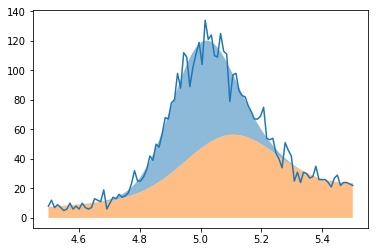

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.special import erf
from spectrocrunch.math import fit1d

# Signal and background within a certain ROI
S = 18.
B = 30.

# Signal parameters
sigma = 0.1
peakpos = 5
k = 5
a = peakpos-sigma*k
b = peakpos+sigma*k

# A is the area within interval [a,b]
gaussian = lambda x,A,u,sigma: A/erf(k/np.sqrt(2))*np.exp(-(x-u)**2/(2.*sigma**2))/(np.sqrt(2*np.pi)*sigma)
line = lambda x,A,m: m*x + (A - m*(b**2-a**2)/2.)/(b-a)

# Verify
#from scipy.integrate import quad
#print quad(lambda x: gaussian(x,1,peakpos,sigma),a,b)
#print quad(lambda x: line(x,1,0.1),a,b)

# Background parameters
slope = B*0.5/(b-a)
Bfracg = 0.5
sigma2 = sigma*1.5
peakpos2 = peakpos+0.1

# Profiles
x = np.linspace(a,b,100)
yS = gaussian(x,S,peakpos,sigma)
yB = line(x,B,0.1)
yB = line(x,B*(1-Bfracg),slope)+gaussian(x,B*Bfracg,peakpos2,sigma2)
yT = yS+yB
T = S+B

# Figures-of-merit
A = np.stack([yS/S,yB/B],axis=-1)
cov = fit1d.lstsq_cov(A,vare=yT)
cor = fit1d.cor_from_cov(cov)
rSB = cor[0,1]
sS,sB = np.sqrt(np.diag(cov))
siS,siB = fit1d.lstsq_std_indep(A,vare=yT)

print("SNR: {}".format(S/np.sqrt(T+B)))
print("ESR (dependent): {} %".format(sS/S*100))
print("ESR (independent): {} %".format(siS/S*100))
print("S-B correlation: {}".format(rSB))

# Plot
y = np.random.poisson(np.round(yT).astype(int))
plt.plot(x,y)
plt.fill_between(x,yT,yB,alpha=0.5)
plt.fill_between(x,yB,0,alpha=0.5)

plt.show()